# 3D Semantic Map Building
In this notebook, we load the RGB-D images and poses generated from `Generate_trajectory.ipynb`, and build a 3D map

In [1]:
import numpy as np
from tqdm import tqdm
import cv2
import matplotlib.pyplot as plt
import open3d as o3d

from src.features.mapping import SemanticMap3DBuilder
from src.config import default_map_builder_cfg, default_sim_cfg

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
TRAJECTORY = "00001-UVdNNRcVyV1"
DEPTH_MAP_DIR = f"../data/interim/trajectories/train/{TRAJECTORY}/D"
RGB_IMAGE_DIR = f"../data/interim/trajectories/train/{TRAJECTORY}/RGB"
POSITIONS_FILE = f"../data/interim/trajectories/train/{TRAJECTORY}/positions.npy"
ROTATIONS_FILE = f"../data/interim/trajectories/train/{TRAJECTORY}/rotations.npy"

Create map builder

In [3]:
sim_cfg = default_sim_cfg()
map_builder_cfg = default_map_builder_cfg()
map_builder_cfg.NUM_SEMANTIC_CLASSES = 3
map_builder_cfg.RESOLUTION = 0.05
map_builder_cfg.MAP_SIZE = [5, 2.0, 5]
map_builder = SemanticMap3DBuilder(map_builder_cfg, sim_cfg)


Load poses, rgb images and depth images. Create semantic map, with RGB images as a placeholder for semantic labels

In [4]:
rotations = np.load(ROTATIONS_FILE).view(dtype=np.quaternion)
positions = np.load(POSITIONS_FILE)

map_builder.clear()
for i in tqdm(range(400)):
    depth_map = np.load(f"{DEPTH_MAP_DIR}/{i}.npy")
    rgb_image = cv2.imread(f"{RGB_IMAGE_DIR}/{i}.png")
    rgb_image = cv2.cvtColor(rgb_image, cv2.COLOR_BGR2RGB)
    rgb_image = rgb_image / 255
    pose = (positions[i], rotations[i])
    map_builder.update_point_cloud(rgb_image, depth_map, pose)

map_builder.update_semantic_map()

100%|██████████| 400/400 [00:24<00:00, 16.62it/s]


Get point cloud and visualize

In [5]:
pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(map_builder.point_cloud)
colour = map_builder.point_cloud_semantic_labels
pcd.colors = o3d.utility.Vector3dVector(colour)
o3d.visualization.draw_geometries([pcd])

Get 3D Semantci map (i.e. Voxel grid)

In [6]:
start = positions[0]
end = positions[-2]
map_at_start = map_builder.semantic_map_at_pose((start,0))
map_at_end = map_builder.semantic_map_at_pose((end,0))

Visualize voxel grids

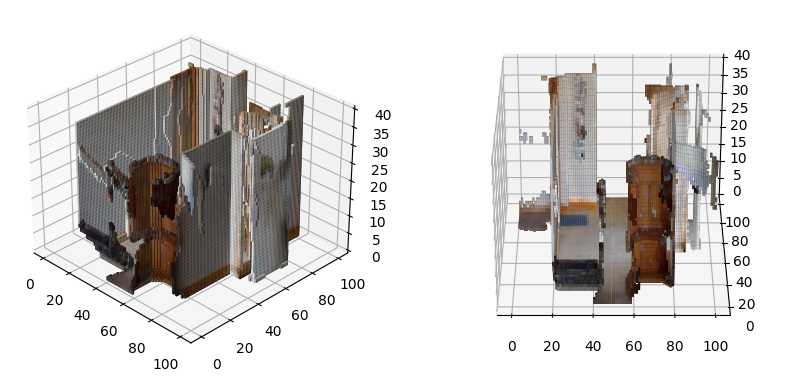

In [7]:
%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D

map_at_end_T = np.transpose(map_at_end, (0,2,1,3))
map_at_start_T = np.transpose(map_at_start, (0,2,1,3))

# Plot 3d voxel grid
fig = plt.figure(figsize=(10, 5))
ax1 = fig.add_subplot(121, projection='3d')
ax2 = fig.add_subplot(122, projection='3d')
ax1.voxels(map_at_start_T[:,:,:,0], facecolors=map_at_start_T[:,:,:,1:])
ax2.voxels(map_at_start_T[:,:,:,0], facecolors=map_at_start_T[:,:,:,1:])
ax1.view_init(azim=-45)
ax2.view_init(azim=-90)
plt.show()


In [8]:
%matplotlib inline

from ipywidgets import interact

def plot_top_view(index):
    position = positions[index]
    map_at_position = map_builder.semantic_map_at_pose((position,0))
    map_top_view = map_at_position.max(axis=1)[:,:,1:]
    plt.imshow(map_top_view)

interact(plot_top_view, index=(0, len(positions)-1, 1))


interactive(children=(IntSlider(value=199, description='index', max=399), Output()), _dom_classes=('widget-int…

<function __main__.plot_top_view(index)>